# ETC Fibers

Analyze exposures with backlit ETC fibers taken 20220317.  See [DESI-6735](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=6735) for details.

In [1]:
%matplotlib inline

In [2]:
import sys
import pathlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import fitsio

In [5]:
import pandas as pd

In [6]:
import astropy.table

In [7]:
import fpoffline.fvc

In [8]:
sys.path.insert(0, '/global/homes/d/dkirkby/DESI/code/desimeter/py')
import desimeter
print(desimeter.__file__)

/global/homes/d/dkirkby/DESI/code/desimeter/py/desimeter/__init__.py


In [9]:
import desimeter.processfvc
import desimeter.io
import desimeter.circles
import desimeter.transform.fvc2fp
import desimeter.transform.xy2qs
import desimeter.transform.pos2ptl
import desimeter.transform.ptl2fp

## Datasets

In [16]:
DESI = pathlib.Path('/global/cfs/cdirs/desi')
DATA = DESI /  'spectro' / 'data'
assert DATA.exists()

In [10]:
def stack_fvc(path, expids, ext='F0000', verbose=True):
    path = pathlib.Path(path)
    if not path.exists():
        raise ValueError('Invalid path: {path}')
    stack = np.zeros((6000,6000), np.float32)
    tot_exptime = 0
    for expid in expids:
        exptag = str(expid).zfill(8)
        filename = path / exptag / f'fvc-{exptag}.fits.fz'
        if not filename.exists():
            raise ValueError('Missing file: {filename}')
        hdr = fitsio.read_header(str(filename), ext=ext)
        tot_exptime += hdr.get('EXPTIME', 0)
        data = fitsio.read(str(filename), ext=ext)
        stack += data
    if verbose:
        print(f'Stacked {tot_exptime:.1f}s from {len(expids)} exposures.')
    return stack

In [12]:
seriesA = stack_fvc(DATA / '20220317', range(126517, 126527))

Stacked 20.0s from 10 exposures.


In [13]:
seriesB = stack_fvc(DATA / '20220317', range(126529, 126539))

Stacked 20.0s from 10 exposures.


In [14]:
seriesC = stack_fvc(DATA / '20220317', range(126539, 126549))

Stacked 10.0s from 10 exposures.


In [15]:
seriesD = stack_fvc(DATA / '20220317', range(126549, 126559))

Stacked 10.0s from 10 exposures.


In [16]:
seriesAp = fpoffline.fvc.process_back_illuminated(seriesA)

In [17]:
seriesBp = fpoffline.fvc.process_back_illuminated(seriesB)

In [18]:
seriesCp = fpoffline.fvc.process_back_illuminated(seriesC)

In [19]:
seriesDp = fpoffline.fvc.process_back_illuminated(seriesD)

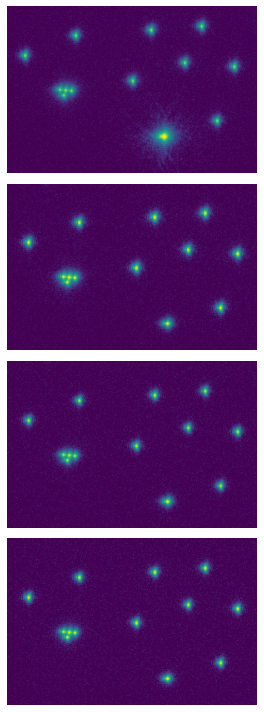

In [20]:
def thumbnails():
    XY = slice(200, 400), slice(3900, 3600, -1)
    fig, axes = plt.subplots(4, 1, figsize=(4, 10))
    for (ax,D) in zip(axes, (seriesAp, seriesBp, seriesCp, seriesDp)):
        ax.imshow(D[XY], origin='lower')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('etc-thumbnails.png')
    
thumbnails()

## ETC Fiber Locations

In [10]:
metrology = desimeter.io.load_metrology()

In [47]:
def fit_spots(night=20220317, expid=126529):

    ftag = str(expid).zfill(8)
    file = DATA / '20220317' / ftag / f'fvc-{ftag}.fits.fz'
    assert file.exists()
    # Use desimeter to find the back-illuminated spots.
    spots = desimeter.processfvc.process_fvc(str(file), use_subprocess=False)    
    # Select ETC fibers.
    sel = np.isin(spots['LOCATION'] % 1000, (461, 501))
    etc = spots[sel][['LOCATION','XPIX','YPIX','XERR','YERR','X_FP','Y_FP','COUNTS']]
    print(f'Found {len(etc)} ETC fibers in expid {expid}')
    return etc

In [11]:
# Omit first exposure without fiducials
expids = list(range(126517, 126527)) + list(range(126529, 126539)) + list(range(126539, 126549)) + list(range(126549, 126559))

In [124]:
# Output from this loop is very verbose unless cached results are found
for expid in expids:
    etc = fit_spots(expid=expid)
    etc.write(f'etc-{expid}.csv', overwrite=True)

using previously processed /tmp/fvc-00126517.csv
Found 16 ETC fibers in expid 126517
using previously processed /tmp/fvc-00126518.csv
Found 16 ETC fibers in expid 126518
using previously processed /tmp/fvc-00126519.csv
Found 16 ETC fibers in expid 126519
using previously processed /tmp/fvc-00126520.csv
Found 16 ETC fibers in expid 126520
using previously processed /tmp/fvc-00126521.csv
Found 16 ETC fibers in expid 126521
using previously processed /tmp/fvc-00126522.csv
Found 16 ETC fibers in expid 126522
using previously processed /tmp/fvc-00126523.csv
Found 16 ETC fibers in expid 126523
using previously processed /tmp/fvc-00126524.csv
Found 16 ETC fibers in expid 126524
using previously processed /tmp/fvc-00126525.csv
Found 16 ETC fibers in expid 126525
using previously processed /tmp/fvc-00126526.csv
Found 16 ETC fibers in expid 126526
using previously processed /tmp/fvc-00126529.csv
Found 15 ETC fibers in expid 126529
using previously processed /tmp/fvc-00126530.csv
Found 15 ETC fib

Read index table for ETC fibers generated from [here](https://observablehq.com/@dkirkby/desi-fp-index):

In [12]:
ETCindex = pd.read_csv('ETC-index.csv')
ETCindex['LOCATION'] = ETCindex.PTL_LOC * 1000 + ETCindex.DEV_LOC

In [13]:
def combine():
    mask = np.zeros((10,2,40), bool)
    counts = np.zeros((10,2,40))
    xfp = np.zeros((10,2,40))
    yfp = np.zeros((10,2,40))
    err = np.zeros((10,2,40))
    for i,expid in enumerate(expids):
        data = pd.read_csv(f'etc-{expid}.csv')
        for j, loc in enumerate((461, 501)):
            sel = data.LOCATION % 1000 == loc
            ptl = data.LOCATION[sel] // 1000
            mask[ptl,j,i] = True
            counts[ptl,j,i] = data.COUNTS[sel]
            xfp[ptl,j,i] = data.X_FP[sel]
            yfp[ptl,j,i] = data.Y_FP[sel]
            err[ptl,j,i] = np.hypot(data.XERR[sel], data.YERR[sel])

    # Get subset of fibers that are always found
    always = np.all(mask, axis=2)

    # Normalize the counts to the mean counts of this subset in each exposure.
    norm = np.mean(counts[always], axis=0)
    counts /= norm

    # Calculate weighted mean quantities over exposures.
    wgts = np.divide(1., err, out=np.zeros_like(err), where=err>0)
    wsum = wgts.sum(axis=2)
    wsuminv = np.divide(1., wsum, out=np.zeros_like(wsum), where=wsum>0)

    transmit = np.sum(wgts * counts, axis=2) * wsuminv
    xfocal = np.sum(wgts * xfp, axis=2) * wsuminv
    yfocal = np.sum(wgts * yfp, axis=2) * wsuminv
    xfocal[transmit == 0] = np.nan
    yfocal[transmit == 0] = np.nan

    out = pd.DataFrame(ETCindex[['DEV_ID', 'LOCATION']])
    out.sort_values(by='LOCATION', ignore_index=True, inplace=True)

    out['XMIT'] = transmit.reshape(-1)
    out['X_FP'] = xfocal.reshape(-1)
    out['Y_FP'] = yfocal.reshape(-1)

    return out

ETCfibers = combine()

## Compare with Offline Snapshot

What values are currently in the [daily snapshots](https://data.desi.lbl.gov/desi/engineering/focalplane/calibration/) for ETC fibers?

In [17]:
def get_snapshot(night):
    DIR = DESI / 'engineering' / 'focalplane' / 'calibration'
    files = sorted(DIR.glob(str(night) + 'T*.ecsv'))
    if len(files) == 0:
        print(f'No snapshot found for {night}')
    dump = astropy.table.Table.read(files[0])
    ETCdump = dump[np.isin(dump['DEVICE_LOC'], (461, 501))]
    ETCdump['LOCATION'] = ETCdump['PETAL_LOC'] * 1000 + ETCdump['DEVICE_LOC']
    ETCdump.sort('LOCATION')
    return ETCdump #[['POS_ID', 'OBS_X','OBS_Y', 'POS_T', 'POS_P']]

In [18]:
dump_before = get_snapshot(20220320)

Verify that the ETC info was constant before the 20220321 update:

In [20]:
np.all(
    get_snapshot(20220201)[['POS_ID', 'OBS_X','OBS_Y', 'POS_T', 'POS_P']] ==
    dump_before[['POS_ID', 'OBS_X','OBS_Y', 'POS_T', 'POS_P']])

True

In [21]:
dump_after = get_snapshot(20220322)

## Convert FP XY to Angles TP

Use desimeter to convert the measured FP locations to internal angles that we can manually load into the moves DB:

In [25]:
def set_angles(T=ETCfibers, CALIB=dump_before):
    
    POS_T = np.zeros(len(T))
    POS_P = np.zeros(len(T))
    
    for petal_loc in range(10):
        tsel = T['LOCATION'] // 1000 == petal_loc
        tloc = np.asarray(T['LOCATION'][tsel] % 1000)
        # Convert from FP to flat coords
        xptl, yptl, _ = desimeter.transform.ptl2fp.fp2ptl(
            petal_loc, T['X_FP'][tsel], T['Y_FP'][tsel])
        xflat, yflat = desimeter.transform.pos2ptl.ptl2flat(xptl, yptl)
        # Lookup calibrations for this petal.
        csel = CALIB['PETAL_LOC'] == petal_loc
        cloc = np.asarray(CALIB['DEVICE_LOC'][csel])
        sorter = np.argsort(cloc)
        idx = sorter[np.searchsorted(cloc, tloc, sorter=sorter)]
        assert np.all(cloc[idx] == tloc)
        x0 = CALIB['OFFSET_X'][csel][idx]; y0 = CALIB['OFFSET_Y'][csel][idx]
        r1 = CALIB['LENGTH_R1'][csel][idx]; r2 = CALIB['LENGTH_R2'][csel][idx]
        T0 = CALIB['OFFSET_T'][csel][idx]; P0 = CALIB['OFFSET_P'][csel][idx]
        DT = CALIB['PHYSICAL_RANGE_T'][idx]; DP = CALIB['PHYSICAL_RANGE_P'][idx]
        # Convert from flat coords to angles
        xloc = desimeter.transform.pos2ptl.flat2loc(xflat, x0)
        yloc = desimeter.transform.pos2ptl.flat2loc(yflat, y0)
        Text, Pext, unreachable = desimeter.transform.pos2ptl.loc2ext(xloc, yloc, r1, r2, T0, P0)
        assert not np.any(unreachable)
        POS_T[tsel] = desimeter.transform.pos2ptl.ext2int(Text, T0)
        POS_P[tsel] = desimeter.transform.pos2ptl.ext2int(Pext, P0)

    T['T_INT'] = POS_T
    T['P_INT'] = POS_P        
    T.to_csv('ETC-fibers.csv', index=False)

    return T

ETCfibers = set_angles()

In [26]:
ETCfibers

,DEV_ID,LOCATION,XMIT,X_FP,Y_FP,T_INT,P_INT
0,M04529,461,1.235668,-95.709973,-401.759361,-43.057298,131.298594
1,M02956,501,1.061375,-42.353907,-408.140490,-78.761990,134.107668
2,M04133,1461,1.066551,158.043808,-377.760270,65.425649,143.841567
3,M03156,1501,0.618137,205.824718,-352.705915,-2.543042,174.042067
4,M04283,2461,1.073576,350.093829,-214.311209,62.221279,174.616135
5,M05607,2501,0.909670,373.284857,-164.374548,88.103800,172.621383
6,M04478,3461,0.965647,409.205736,32.338760,85.083009,175.476800
7,M03990,3501,1.007959,398.629916,86.364826,106.040542,173.121295
8,M01190,4461,0.000000,NaN,NaN,NaN,NaN
9,M02792,4501,0.000000,NaN,NaN,NaN,NaN


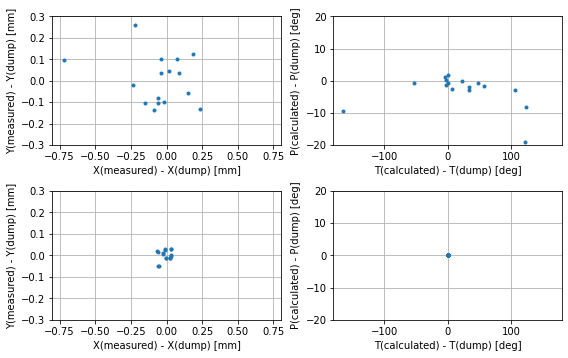

In [40]:
def compare():
    
    before = dump_before[['POS_ID', 'OBS_X','OBS_Y', 'POS_T', 'POS_P']].to_pandas(index='POS_ID').join(ETCfibers.set_index('DEV_ID'))
    after = dump_after[['POS_ID', 'OBS_X','OBS_Y', 'POS_T', 'POS_P']].to_pandas(index='POS_ID').join(ETCfibers.set_index('DEV_ID'))

    fig, axes = plt.subplots(2, 2, figsize=(8, 5))

    for ((left,right), both) in zip(axes, (before, after)):
        
        ok = np.isfinite(both.X_FP)

        left.plot(both.X_FP[ok] - both.OBS_X[ok], both.Y_FP[ok] - both.OBS_Y[ok], '.')
        left.set_xlabel('X(measured) - X(dump) [mm]')
        left.set_ylabel('Y(measured) - Y(dump) [mm]')
        left.set_xlim(-0.8, 0.8)
        left.set_ylim(-0.3, 0.3)
        left.grid()

        right.plot(np.fmod(both.T_INT[ok] - both.POS_T[ok] + 180, 360) - 180, both.P_INT[ok] - both.POS_P[ok], '.')
        right.set_xlabel('T(calculated) - T(dump) [deg]')
        right.set_ylabel('P(calculated) - P(dump) [deg]')
        right.set_xlim(-180, 180)
        right.set_ylim(-20, 20)
        right.grid()
        
    plt.tight_layout()
    plt.savefig('etc-compare.png')

compare()

In [37]:
def updateDB():
    print('POS_ID,POS_T,POS_P,COMMIT_POS_T,COMMIT_POS_P')
    for i, row in ETCfibers.dropna().iterrows():
        print(f'{row.DEV_ID},{np.round(row.T_INT,3)},{np.round(row.P_INT,3)},True,True')

updateDB()

POS_ID,POS_T,POS_P,COMMIT_POS_T,COMMIT_POS_P
M04529,-43.057,131.299,True,True
M02956,-78.762,134.108,True,True
M04133,65.426,143.842,True,True
M03156,-2.543,174.042,True,True
M04283,62.221,174.616,True,True
M05607,88.104,172.621,True,True
M04478,85.083,175.477,True,True
M03990,106.041,173.121,True,True
M01727,20.065,144.582,True,True
M06214,-87.115,119.418,True,True
M06009,3.27,166.205,True,True
M03943,19.545,177.616,True,True
M03159,174.639,177.558,True,True
M02732,-136.966,174.826,True,True
M04583,18.104,178.68,True,True
M05070,78.086,143.128,True,True
